<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_2_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in Keras**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning [[Video]](https://www.youtube.com/watch?v=dMUmHsktl04&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_1_timeseries.ipynb)
* **Part 10.2: Programming LSTM with Keras and TensorFlow** [[Video]](https://www.youtube.com/watch?v=wY0dyFgNCgY&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_2_lstm.ipynb)
* Part 10.3: Text Generation with Keras and TensorFlow [[Video]](https://www.youtube.com/watch?v=6ORnRAz3gnA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_3_text_generation.ipynb)
* Part 10.4: Introduction to Transformers [[Video]](https://www.youtube.com/watch?v=Z7FIdKVQ7kc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_4_intro_transformers.ipynb)
* Part 10.5: Transformers for Timeseries [[Video]](https://www.youtube.com/watch?v=SX67Mni0Or4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


# Part 10.2: Programming LSTM with Keras and TensorFlow

So far, the neural networks that we’ve examined have always had forward connections. Neural networks of this type always begin with an input layer connected to the first hidden layer. Each hidden layer always connects to the next hidden layer. The final hidden layer always connects to the output layer. This manner of connection is why these networks are called “feedforward.”  Recurrent neural networks are not as rigid, as backward linkages are also allowed. A recurrent connection links a neuron in a layer to either a previous layer or the neuron itself. Most recurrent neural network architectures maintain the state in the recurrent connections. Feedforward neural networks don’t keep any state. 

## Understanding LSTM

Long Short Term Memory (LSTM) layers are a type of recurrent unit that you often use with deep neural networks.[[Cite:hochreiter1997long]](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320) For TensorFlow, you can think of LSTM as a layer type that you can combine with other layer types, such as dense. LSTM makes use of two transfer function types internally.  

The first type of transfer function is the sigmoid.  This transfer function type is used form gates inside of the unit.  The sigmoid transfer function is given by the following equation:

$ \mbox{S}(t) = \frac{1}{1 + e^{-t}} $

The second type of transfer function is the hyperbolic tangent (tanh) function, which allows you to scale the output of the LSTM. This functionality is similar to how we have used other transfer functions in this course.  

We provide the graphs for these functions here:

Sigmoid


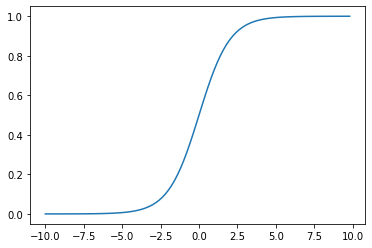

Hyperbolic Tangent(tanh)


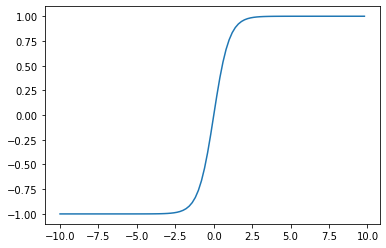

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a

def f2(x):
    a = []
    for item in x:
        a.append(math.tanh(item))
    return a

x = np.arange(-10., 10., 0.2)
y1 = sigmoid(x)
y2 = f2(x)

print("Sigmoid")
plt.plot(x,y1)
plt.show()

print("Hyperbolic Tangent(tanh)")
plt.plot(x,y2)
plt.show()

Both of these two functions compress their output to a specific range.  For the sigmoid function, this range is 0 to 1.  For the hyperbolic tangent function, this range is -1 to 1.

LSTM maintains an internal state and produces an output.  The following diagram shows an LSTM unit over three timeslices: the current time slice (t), as well as the previous (t-1) and next (t+1) slice, as demonstrated by Figure 10.LSTM.

**Figure 10.LSTM: LSTM Layers**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm1.png "LSTM Layers")

The values $\hat{y}$ are the output from the unit; the values ($x$) are the input to the unit, and the values $c$ are the context values.  The output and context values always feed their output to the next time slice.  The context values allow the network to maintain the state between calls.  Figure 10.ILSTM shows the internals of a LSTM layer.

**Figure 10.ILSTM: Inside a LSTM Layer**
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")

A LSTM unit consists of three gates:

* Forget Gate ($f_t$) - Controls if/when the context is forgotten. (MC)
* Input Gate ($i_t$) - Controls if/when the context should remember a value. (M+/MS)
* Output Gate ($o_t$) - Controls if/when the remembered value is allowed to pass from the unit. (RM)


## Simple Keras LSTM Example

The following code creates the LSTM network, an example of an RNN for classification.  The following code trains on a data set (x) with a max sequence size of 6 (columns) and six training elements (rows)

In [3]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
import numpy as np

max_features = 4 # 0,1,2,3 (total of 4)
x = [
    [[0],[1],[1],[0],[0],[0]],
    [[0],[0],[0],[2],[2],[0]],
    [[0],[0],[0],[0],[3],[3]],
    [[0],[2],[2],[0],[0],[0]],
    [[0],[0],[3],[3],[0],[0]],
    [[0],[0],[0],[0],[1],[1]]
]
x = np.array(x,dtype=np.float32)
y = np.array([1,2,3,2,3,1],dtype=np.int32)

# Convert y2 to dummy variables
y2 = np.zeros((y.shape[0], max_features),dtype=np.float32)
y2[np.arange(y.shape[0]), y] = 1.0
print(y2)

print('Build model...')
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, \
               input_shape=(None, 1)))
model.add(Dense(4, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x,y2,epochs=200)
pred = model.predict(x)
predict_classes = np.argmax(pred,axis=1)
print("Predicted classes: {}",predict_classes)
print("Expected classes: {}",y)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]
Build model...
Train...
Epoch 1/200
1/1 [==============================] - 6s 6s/step - loss: 0.6885 - accuracy: 0.3333
Epoch 2/200
1/1 [==============================] - 0s 45ms/step - loss: 0.6807 - accuracy: 0.3333
Epoch 3/200
1/1 [==============================] - 0s 38ms/step - loss: 0.6773 - accuracy: 0.3333
Epoch 4/200
1/1 [==============================] - 0s 37ms/step - loss: 0.6684 - accuracy: 0.3333
Epoch 5/200
1/1 [==============================] - 0s 33ms/step - loss: 0.6556 - accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 37ms/step - loss: 0.6555 - accuracy: 0.3333
Epoch 7/200
1/1 [==============================] - 0s 31ms/step - loss: 0.6397 - accuracy: 0.1667
Epoch 8/200
1/1 [==============================] - 0s 40ms/step - loss: 0.6376 - accuracy: 0.3333
Epoch 9/200
1/1 [==============================] - 0s 39ms/step - loss: 0.6302 - accuracy: 0.3333
Epoch

We can now present a sequence directly to the model for classification.

In [4]:
def runit(model, inp):
    inp = np.array(inp,dtype=np.float32)
    pred = model.predict(inp)
    return np.argmax(pred[0])

print( runit( model, [[[0],[0],[0],[0],[0],[1]]] ))


1


## Sun Spots Example

This section shows an example of RNN regression to predict sunspots.  You can find the data files needed for this example at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

The following code loads the sunspot file:


In [5]:
import pandas as pd
import os
  
names = ['year', 'month', 'day', 'dec_year', 'sn_value' , 
         'sn_error', 'obs_num', 'unused1']
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
    sep=';',header=None,names=names,
    na_values=['-1'], index_col=False)

print("Starting file:")
print(df[0:10])

print("Ending file:")
print(df[-10:])

Starting file:
   year  month  day  dec_year  sn_value  sn_error  obs_num  unused1
0  1818      1    1  1818.001        -1       NaN        0        1
1  1818      1    2  1818.004        -1       NaN        0        1
2  1818      1    3  1818.007        -1       NaN        0        1
3  1818      1    4  1818.010        -1       NaN        0        1
4  1818      1    5  1818.012        -1       NaN        0        1
5  1818      1    6  1818.015        -1       NaN        0        1
6  1818      1    7  1818.018        -1       NaN        0        1
7  1818      1    8  1818.021        65      10.2        1        1
8  1818      1    9  1818.023        -1       NaN        0        1
9  1818      1   10  1818.026        -1       NaN        0        1
Ending file:
       year  month  day  dec_year  sn_value  sn_error  obs_num  unused1
72855  2017      6   21  2017.470        35       1.0       41        0
72856  2017      6   22  2017.473        24       0.8       39        0
72857  2

As you can see, there is quite a bit of missing data near the end of the file.  We want to find the starting index where the missing data no longer occurs.  This technique is somewhat sloppy; it would be better to find a use for the data between missing values.  However, the point of this example is to show how to use LSTM with a somewhat simple time-series.

In [6]:
start_id = max(df[df['obs_num'] == 0].index.tolist())+1  # Find the last zero and move one beyond
print(start_id)
df = df[start_id:] # Trim the rows that have missing observations

11314


In [7]:
df['sn_value'] = df['sn_value'].astype(float)
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

spots_train = df_train['sn_value'].tolist()
spots_test = df_test['sn_value'].tolist()

print("Training set has {} observations.".format(len(spots_train)))
print("Test set has {} observations.".format(len(spots_test)))

Training set has 55160 observations.
Test set has 6391 observations.


To create an algorithm that will predict future values, we need to consider how to encode this data to be presented to the algorithm. The data must be submitted as sequences, using a sliding window algorithm to encode the data. We must define how large the window will be. Consider an n-sized window. Each sequence's $x$ values will be a $n$ data points sequence. The $y$'s will be the next value, after the sequence, that we are trying to predict. You can use the following function to take a series of values, such as sunspots, and generate sequences ($x$) and predicted values ($y$).

In [8]:
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,spots_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE,spots_test)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (55150, 10, 1)
Shape of test set: (6381, 10, 1)


We can see the internal structure of the training data. The first dimension is the number of training elements, the second indicates a sequence size of 10, and finally, we have one data point per timeslice in the window.

In [9]:
x_train.shape

(55150, 10, 1)

We are now ready to build and train the model.

In [ ]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

print('Build model...')
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0,\
                   input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, 
                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)

Build model...
Train...
Epoch 1/1000
1724/1724 - 12s - loss: 1392.9260 - val_loss: 212.4303 - 12s/epoch - 7ms/step
Epoch 2/1000
1724/1724 - 10s - loss: 516.7653 - val_loss: 239.7139 - 10s/epoch - 6ms/step
Epoch 3/1000
1724/1724 - 10s - loss: 509.0716 - val_loss: 227.2393 - 10s/epoch - 6ms/step
Epoch 4/1000
1724/1724 - 10s - loss: 503.2472 - val_loss: 257.9693 - 10s/epoch - 6ms/step
Epoch 5/1000
1724/1724 - 10s - loss: 498.1863 - val_loss: 226.4870 - 10s/epoch - 6ms/step
Epoch 6/1000
1724/1724 - 10s - loss: 499.1180 - val_loss: 208.2820 - 10s/epoch - 6ms/step
Epoch 7/1000
1724/1724 - 10s - loss: 498.4828 - val_loss: 224.2135 - 10s/epoch - 6ms/step
Epoch 8/1000
1724/1724 - 10s - loss: 497.6813 - val_loss: 253.0776 - 10s/epoch - 6ms/step
Epoch 9/1000
1724/1724 - 10s - loss: 496.7933 - val_loss: 211.7351 - 10s/epoch - 6ms/step
Epoch 10/1000
1724/1724 - 10s - loss: 497.0393 - val_loss: 215.1721 - 10s/epoch - 6ms/step
Epoch 11/1000
Restoring model weights from the end of the best epoch: 6.
1

Finally, we evaluate the model with RMSE.

In [ ]:
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))